Сперва нам необходимо установить нужные версии библиотек `gym` и `atari-py`. Также, нужна библиотека `imageio` для воспоизведения полученного результата в видео.

In [1]:
#В связи с недавним обновлением библиотеки gym, попытки создать игровую среду pong-v0 (или любую другую) теперь вызывают ошибку. 
#Следующий код является временной мерой для избежание этой ошибки.

!pip install gym==0.18.0
!pip install atari-py==0.2.5
!pip install imageio==2.4.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import tensorflow_probability as tfp                       #Импортируем библиотеку - Тензорфлоу Вероятности (позволяет генерить рандомные значения из заданного распределения в тензорфлоу)
import tensorflow as tf                                    #Импортируем Тензорфлоу

import gym                                                 #Импортируем среду Gym
import numpy as np                                         #Импортируем библиотеку NumPy
from tensorflow.keras.layers import *                      #Импортируем все слои с Кераса
from tensorflow.keras import utils                         #Импортируем утилиты Кераса
from tensorflow.keras.optimizers import RMSprop, Adam      #Импортируем оптимизаторы Кераса
from tensorflow.keras import backend as K                  #Импортируем бэкэнд Кераса
import matplotlib.pyplot as plt
from google.colab import output                            #Импортируем функцию для управления вывода в колаб-ячейках
from IPython.display import display, clear_output
import cv2                                #Импортируем библиотеку cv2 (нужна для создания видео)
import random

In [3]:
#Класс буфера памяти

class Memory_Buffer:
  def __init__(self, state_size, action_size, memory_size):
    self.memory_size = int(memory_size)
    self.buffer = np.zeros((self.memory_size, 5)).astype(object)
    self.counter = 0
    
  def add_to_memory(self, state, action, reward, next_state, done):
    position_to_write = self.counter % self.memory_size
    self.buffer[position_to_write] = (state, action, reward, next_state, done)
    self.counter += 1
    
  def sample_from_memory(self, batch_size):
    batch = self.buffer[np.random.choice(min(self.counter, self.memory_size), batch_size, replace=False)]
    current_states, actions, rewards, next_states, dones = map(np.stack, zip(*batch))
    return current_states, actions, rewards, next_states, dones

In [4]:
class Actor(tf.keras.models.Model):
  def __init__(self, action_size, epsilon):
    super().__init__()
    self.dense_layer = Dense(256, activation='relu')
    self.mean_layer = Dense(action_size)
    self.standard_deviation_layer = Dense(action_size)
    self.epsilon = epsilon

  def __call__(self, state):
    x = self.dense_layer(state)
    mu = self.mean_layer(x)
    log_sigma = self.standard_deviation_layer(x)
    sigma = tf.exp(log_sigma)

    gaussian_distribution = tfp.distributions.Normal(mu, sigma)
    action = gaussian_distribution.sample()

    action = tf.tanh(action)
    log_pi = gaussian_distribution.log_prob(action) - tf.reduce_sum(tf.math.log(1 - action**2 + self.epsilon), axis=1, keepdims=True)

    return action, log_pi

class Critic(tf.keras.models.Model):
  def __init__(self):
    super().__init__()
    self.dense_layer = Dense(256, activation = 'relu')
    self.value_layer = Dense(1)

  def __call__(self, state, action):
    state_action = tf.concat([state, action], axis=-1)
    x = self.dense_layer(state_action)
    value = self.value_layer(x)
    return value

class Soft_Actor_Critic:
  def __init__(self, state_size, action_size, gamma, tau, batch_size, actor_learning_rate, critic_learning_rate, alpha_learning_rate, memory_size, target_entropy, epsilon):
    self.gamma = gamma
    self.tau = tau
    self.batch_size = batch_size
    self.actor_learning_rate = actor_learning_rate
    self.critic_learning_rate = critic_learning_rate
    self.alpha_learning_rate = alpha_learning_rate
    self.gamma = gamma
    self.tau = tau
    self.target_entropy = tf.constant(target_entropy, dtype=tf.float32)
    self.memory_buffer = Memory_Buffer(state_size, action_size, memory_size)

    self.actor = Actor(action_size, epsilon)
    self.main_critic_1 = Critic()
    self.main_critic_2 = Critic()
    self.target_critic_1 = Critic()
    self.target_critic_2 = Critic()
    self.alpha = tf.Variable(0.0, dtype=tf.float32)

    self.actor_optimizer = Adam(learning_rate = actor_learning_rate)
    self.critic_1_optimizer = Adam(learning_rate = critic_learning_rate)
    self.critic_2_optimizer = Adam(learning_rate = critic_learning_rate)
    self.alpha_optimizer = Adam(learning_rate = alpha_learning_rate)


  def get_actor_action(self, state):
    state = np.array(state, ndmin=2)
    mean, sigma = self.actor(state)
    return mean[0].numpy().tolist()


  def train_Q_networks(self, current_states, actions, rewards, next_states, dones):
    pi_a, log_pi_a = self.actor(current_states)
    Q1_targets = self.target_critic_1(next_states, pi_a)
    Q2_targets = self.target_critic_2(next_states, pi_a)
    Q_minimum = tf.minimum(Q1_targets, Q2_targets)
    soft_Q_values = Q_minimum - self.alpha * log_pi_a
    y_true = rewards + self.gamma * dones * soft_Q_values

    with tf.GradientTape() as tape_1:
      Q1_predictions = self.main_critic_1(current_states, actions)
      critic_1_loss = tf.reduce_mean((Q1_predictions - y_true)**2)
    
    with tf.GradientTape() as tape_2:
      Q2_predictions = self.main_critic_2(current_states, actions)
      critic_2_loss = tf.reduce_mean((Q2_predictions - y_true)**2)

    critic_1_gradients = tape_1.gradient(critic_1_loss, self.main_critic_1.trainable_variables)
    self.critic_1_optimizer.apply_gradients(zip(critic_1_gradients, self.main_critic_1.trainable_variables))
    
    critic_2_gradients = tape_2.gradient(critic_2_loss, self.main_critic_2.trainable_variables)
    self.critic_2_optimizer.apply_gradients(zip(critic_2_gradients, self.main_critic_1.trainable_variables))
    
    self.update_Q_target_weights()


  def train_policy_network(self, current_states):
    with tf.GradientTape() as tape:
      pi_a, log_pi_a = self.actor(current_states)
      Q1_predictions = self.main_critic_1(current_states, pi_a)
      Q2_predictions = self.main_critic_2(current_states, pi_a)
      Q_minimum = tf.minimum(Q1_predictions, Q2_predictions)
      soft_Q_values = Q_minimum - self.alpha * log_pi_a
      actor_loss = -tf.reduce_mean(soft_Q_values)

    actor_gradients = tape.gradient(actor_loss, self.actor.trainable_variables)
    self.actor_optimizer.apply_gradients(zip(actor_gradients, self.actor.trainable_variables))


  def train_alpha_parameter(self, current_states):
    with tf.GradientTape() as tape:
      pi_a, log_pi_a = self.actor(current_states)
      alpha_loss = -tf.reduce_mean(self.alpha*(log_pi_a - self.target_entropy))

    variables = [self.alpha]
    gradients = tape.gradient(alpha_loss, variables)
    self.alpha_optimizer.apply_gradients(zip(gradients, variables))


  def train_iteration(self):
    current_states, actions, rewards, next_states, dones = self.memory_buffer.sample_from_memory(self.batch_size)
    self.train_Q_networks(current_states, actions, rewards, next_states, dones)
    self.train_policy_network(current_states)
    self.train_alpha_parameter(current_states)


  @tf.function
  def update_Q_target_weights(self): 
    for (main, target) in zip(self.main_critic_1.trainable_variables, self.target_critic_1.trainable_variables):       
      target.assign(self.tau * target + (1 - self.tau) * main)

    for (main, target) in zip(self.main_critic_2.trainable_variables, self.target_critic_2.trainable_variables):       
      target.assign(self.tau * target + (1 - self.tau) * main)             

In [5]:
#Создаем функцию для визуализации результата - принимает на вход массив вознаграждений за все эпизоды
def plot_results(rewards):
  output.clear() #Удаляем предидущий вывод ячейки
  plt.figure(figsize = (16, 10)) #Делаем размер графика большим
  plt.plot(rewards, color = 'blue', label = "Вознаграждения за эпизод (сырая)")                                                 #Отрисовываем вознаграждения за эпизоды
  plt.plot(moving_average(rewards), color = 'green', linestyle = '--', label = "Вознаграждения за эпизод (скользящая средняя)") #Отрисовываем скользящие средние вознаграждения
  plt.xlabel("Эпизод", fontsize = 14)                                                                                           #Добавляем лейбл для оси х
  plt.title("История наград во время обучения", fontsize = 20)                                                                  #Добавляем заголовок

  plt.legend()        #Отображаем легенду
  plt.show()          #Отображаем график

#Также мы создадим функцию для подсчета скользящего среднего всех значений.
#Это будет осуществляться через матиматическую свёртку, и мы будем считать скользящее среднее за 10 значений.

def moving_average(data, width = 10): #data - входной массив, width - длина на которое считаем скользящее среднее.
  width = min(width, len(data))       #Длина свёртки (минимум из заданной длины свёртки и длины датасета)
  data = np.concatenate([np.repeat(data[0], width), np.array(data).squeeze()])         #Вместо паддинга из нулей, мы создадим паддинг для свёртки из первого значения массива. Весь паддинг будет слева (в начале массива)
  return (np.convolve(data, np.ones(width), 'valid') / width)[1:]  #Возвращаем результат свёртки данных на фильтр из единиц - наше скользящее среднее

In [6]:
num_training_episodes = 200
max_steps_per_episode = 1000
train_frequency = 20
warmup_steps = 100

In [7]:
def choose_action(soft_actor_critic, env, state):
  if soft_actor_critic.memory_buffer.counter < warmup_steps:
    action = env.action_space.sample()
  else:
    action = soft_actor_critic.get_actor_action(state)
  return action

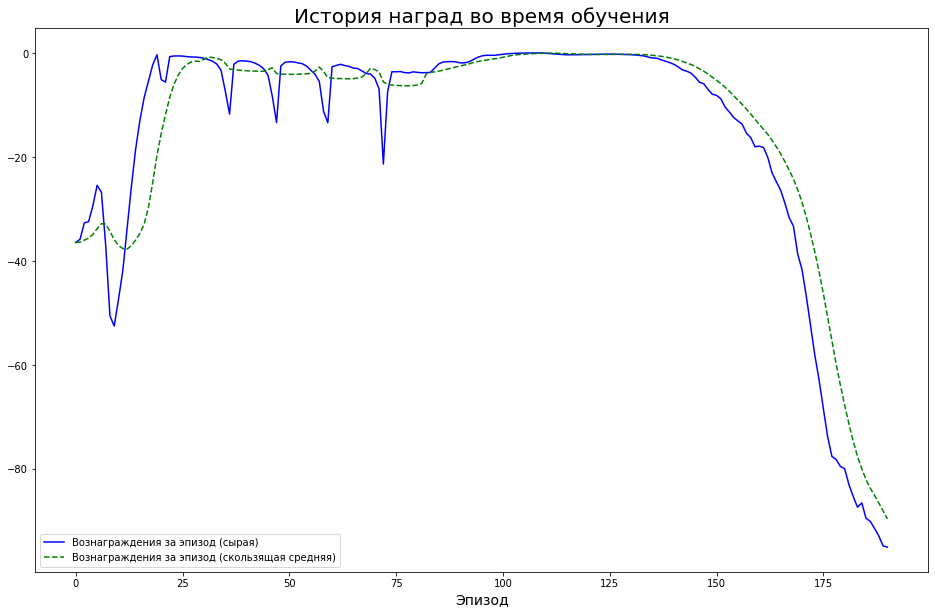

Episode 192 reward: -96.10500369983106
Episode 193 reward: -97.71122782777908
Episode 194 reward: -98.51549760343792
Episode 195 reward: -99.5152051022839
Episode 196 reward: -98.25667379065632
Episode 197 reward: -96.00725294280942
Episode 198 reward: -94.54186779973381
Episode 199 reward: -94.94699175032684
Episode 200 reward: -95.938359726309


In [ ]:
env = gym.make('MountainCarContinuous-v0')

state_size = env.observation_space.shape[0]
action_size = env.action_space.shape[0]

soft_actor_critic = Soft_Actor_Critic(state_size, action_size, gamma=0.99, tau=0.995, batch_size=64, actor_learning_rate=1e-4, critic_learning_rate=1e-4, alpha_learning_rate=1e-4, memory_size=1e5, target_entropy=2, epsilon=1e-16)
all_episode_rewards = []

global_step = 0
for i in range(num_training_episodes):
  current_state = env.reset()
  done = False
  episode_reward = 0
  while not done:
    action = choose_action(soft_actor_critic, env, current_state)
    next_state, reward, done, info = env.step(action)
    soft_actor_critic.memory_buffer.add_to_memory(current_state, action, reward, next_state, done)

    if soft_actor_critic.memory_buffer.counter >= warmup_steps and global_step % train_frequency == 0:
      soft_actor_critic.train_iteration()

    current_state = next_state
    episode_reward += reward
    global_step += 1
  print(f"Episode {i+1} reward: {episode_reward}")
  all_episode_rewards.append(episode_reward)

  if i % 10 == 0 and i > 0:
    plot_results(all_episode_rewards)

# Записываем результат работы сети в видео

Сперва, нам нужно установить несколько зависимостей которые позволят отображать состояние среды в виде картинки.

Весь код для установки зависимостей/создания дисплея является шаблонным - его не нужно тщательно изучать или запомянать синтаксис.

In [ ]:
#Устанавливаем зависимости
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1

In [ ]:
import pyvirtualdisplay #Импортируем библиотеку которая позволит создать дисплей


_display = pyvirtualdisplay.Display(visible=False, size=(1400, 900)) #Создаем дисплей где будем отображать кадры
_ = _display.start() #Запускаем дисплей

In [ ]:
env = gym.make('MountainCarContinuous-v0')
current_state = env.reset()
done = False
video_frames = []
while not done:
  video_frames.append(env.render(mode='rgb_array')) #Добавляем текущий кадр в соответствующий массив
  action = soft_actor_critic.get_actor_action(state)
  state, reward, done, info = env.step(action)      #Подаем предсказанное действие в среду
env.close() #Закрываем среду в конце эпизода

out = cv2.VideoWriter('/content/episode.avi', cv2.VideoWriter_fourcc(*'DIVX'), 30, (500, 500)) #Создаем объект для воспроизведениед видео (задаем путь к файлу видео, формат видео, кадры в секунду, и размер изображений)
for i in range(len(video_frames)):  #В цикле добавляем каждый кадр в видео (делаем предобработку кадра - меняем каналы с RGB в BGR - это нужно потому что cv2 воспринимает каналы как BGR) 
  out.write(cv2.cvtColor(video_frames[i], cv2.COLOR_RGB2BGR))
out.release()                       #Закрываем объект для создания видео

from moviepy.editor import VideoFileClip #Импортируем объект для отображения видео в колабе

clip=VideoFileClip("/content/episode.avi")  #Извлекаем видео из заданного пути (куда мы ранее записыли видео через cv2)  
clip.ipython_display(width = 480, maxduration = 20) #Отображаем видео в колабе